In [3]:
from plot_lib import *
import pandas as pd 
from evaluation import *

DATA_DIR = 'recommender_outputs' 


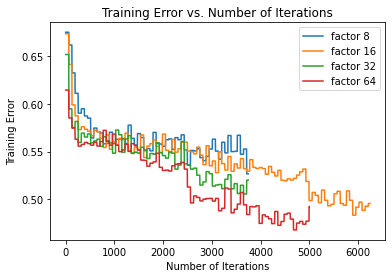

In [4]:
factor_arr = [8, 16, 32, 64]
error_dict = {}
for factor in factor_arr:
    df = pd.read_csv(f'{DATA_DIR}/math-german-no-features-{factor}_loss.csv')
    error_dict[f'factor {factor}'] = [df['loss_value'], df['iteration']]

iteration_error_plot(error_dict)

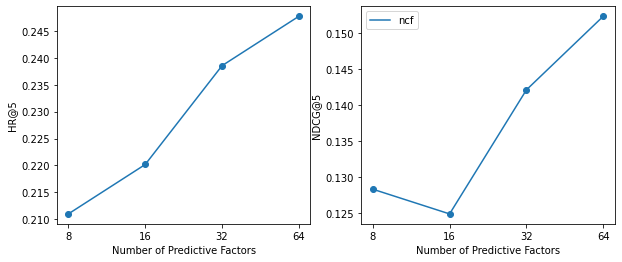

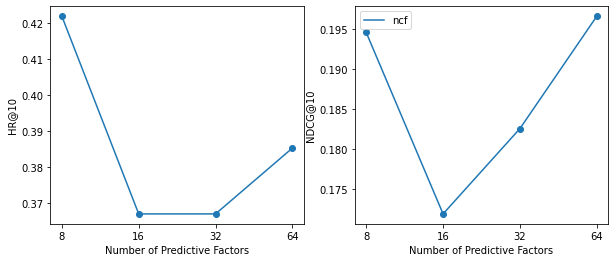

In [5]:

def create_plot_predictive_factor_eval(factor_arr, n):
    hr_dict, ndcg_dict = {'ncf': []}, {'ncf': []}
    for factor in factor_arr:
        hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
        hr_dict['ncf'].append(hr)
        ndcg_dict['ncf'].append(ndcg)
    predictive_factor_eval_plot(factor_arr, hr_dict, ndcg_dict, n)

create_plot_predictive_factor_eval(factor_arr = [8, 16, 32, 64], n=5)
create_plot_predictive_factor_eval(factor_arr = [8, 16, 32, 64], n=10)


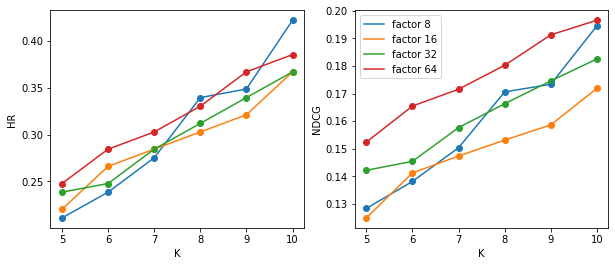

In [6]:
def create_plot_k_eval(k_arr, factor_arr):
    hr_dict, ndcg_dict = {}, {}
    for factor in factor_arr:
        hr_dict[f'factor {factor}'] = []
        ndcg_dict[f'factor {factor}'] = []
        for n in k_arr:
            hr, ndcg  = HitRate_NDCG(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
            hr_dict[f'factor {factor}'].append(hr)
            ndcg_dict[f'factor {factor}'].append(ndcg)
    k_eval_plot(k_arr, hr_dict, ndcg_dict)

create_plot_k_eval([5, 6, 7, 8, 9, 10], [8, 16, 32, 64])


# Create plots from metrics.csv

Copy all the metrics.csv to one single folder, rename with model name (e.g. 'ncf_features_32.csv' or smth), and then run 'collect_stats_from_dir'. Will return a dict containing each model, and for each model containing another dict with the various stats for plotting (training loss & steps, val loss & steps, various val metrics & steps, various test metrics)

In [ ]:

import os 

def collect_stats_from_dir(directory, metrics = ['HitRate@10', 'NDCG@10', 'MRR@10']):
    data = dict()

    if directory[-1] != '/':
        directory = directory + '/'

    for filename in os.listdir(directory):
        if len(filename) <= 4 or filename[-4:] != '.csv':
            continue

        stats = dict()
        df = pd.read_csv(directory + filename)

        train = df[~df['train_loss'].isna()]

        stats[('train_loss','steps')] = (train['train_loss'], train['step'])

        validation = df[~df['val_loss'].isna()]
        
        stats[('val_loss','steps')] = (validation['val_loss'], validation['step'])

        for m in metrics:
            stats[('val_' + m, 'steps')] = (validation[m], validation['step'])

        

        test = df[df['train_loss'].isna()]
        test = test[test['val_loss'].isna()]

        if len(test):
            for m in metrics:
                stats['test_' + m] = test[m].iloc[0]


        data[filename[:-4]] = stats
    
    return data